# Base

In [1]:
from recognizer.utils. constants import DATA_DIR

ANNOTATIONS_DIR = DATA_DIR / "annotations"
IMAGES_DIR = DATA_DIR / "images"

In [2]:
import json

with open(ANNOTATIONS_DIR / "instances_default.json") as f:
    annotations = json.load(f)

In [3]:
annotations.keys()

dict_keys(['licenses', 'info', 'categories', 'images', 'annotations'])

In [4]:
image_id_map = {a["id"]: a["file_name"] for a in annotations["images"]}

The original size of the images is 1920x1080. We will shrink them to 1/5 of that size to train the model efficiently.

In [5]:
IMAGE_INPUT_SIZE = (1920, 1080)

IMAGE_SIZE = (384, 216)

N = 512

In [6]:
import numpy as np
from PIL import Image

images = np.zeros((N, IMAGE_SIZE[1], IMAGE_SIZE[0], 3), dtype=np.uint8)

for img_id, img_filename in image_id_map.items():
    img = Image.open(str(IMAGES_DIR / img_filename))
    img = img.resize(size=IMAGE_SIZE)
    images[img_id - 1] = img

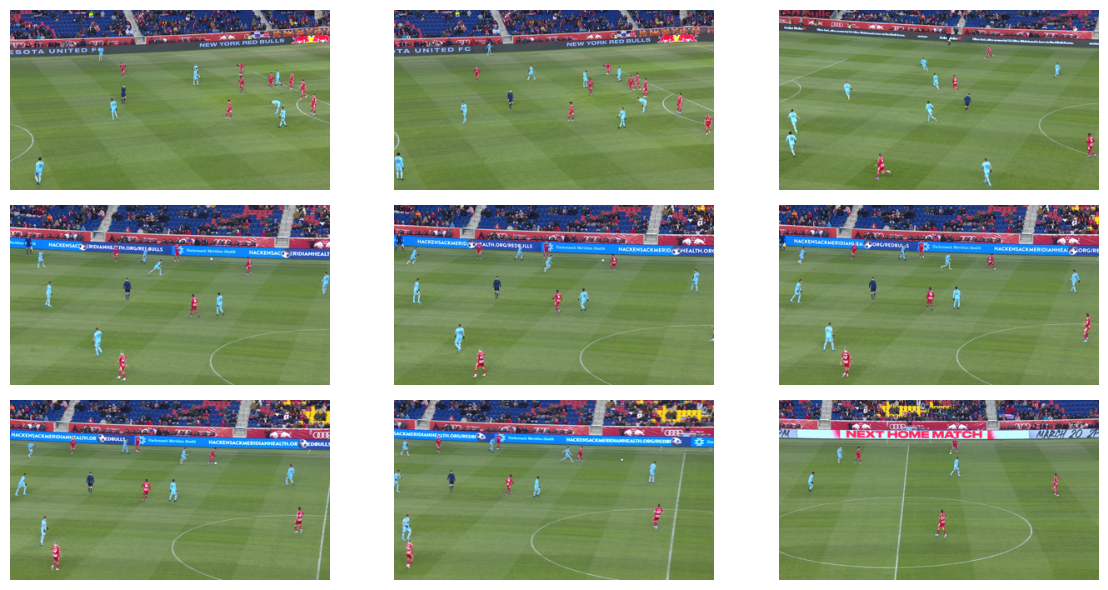

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i]/255)
    plt.axis('off')

fig.tight_layout()

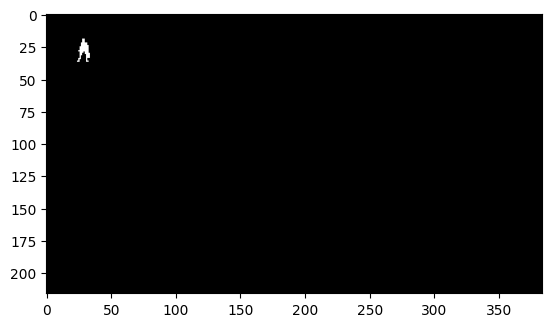

In [8]:
from PIL import ImageDraw

mask = Image.new("1", IMAGE_INPUT_SIZE) # create new image in INPUT_SIZE filled with black (default)
mask_draw = ImageDraw.Draw(mask, '1') # so we can draw on the mask image
mask_draw.polygon(annotations['annotations'][281]['segmentation'][0], fill=1) # draw a player in white
mask = mask.resize(IMAGE_SIZE)
plt.imshow(mask)

In [9]:
masks = np.zeros((N, IMAGE_SIZE[1], IMAGE_SIZE[0]), dtype=bool)

for annotation in annotations["annotations"]:
    # get image id of the annotation
    img_id = annotation["image_id"]
    mask = Image.new("1", IMAGE_INPUT_SIZE)
    mask_draw = ImageDraw.ImageDraw(mask, "1")
    segmentation = annotation["segmentation"][0]
    mask_draw.polygon(segmentation, fill=1)
    bool_array = np.array(mask.resize((IMAGE_SIZE[0], IMAGE_SIZE[1]))) > 0
    masks[img_id - 1] = masks[img_id - 1] | bool_array

In [10]:
masks = masks.reshape(N, IMAGE_SIZE[1], IMAGE_SIZE[0], 1) # Adding channel dimension

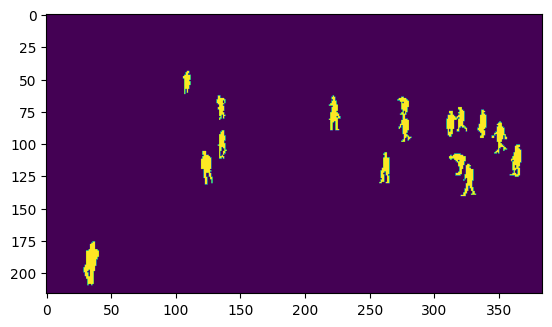

In [11]:
plt.imshow(masks[0])

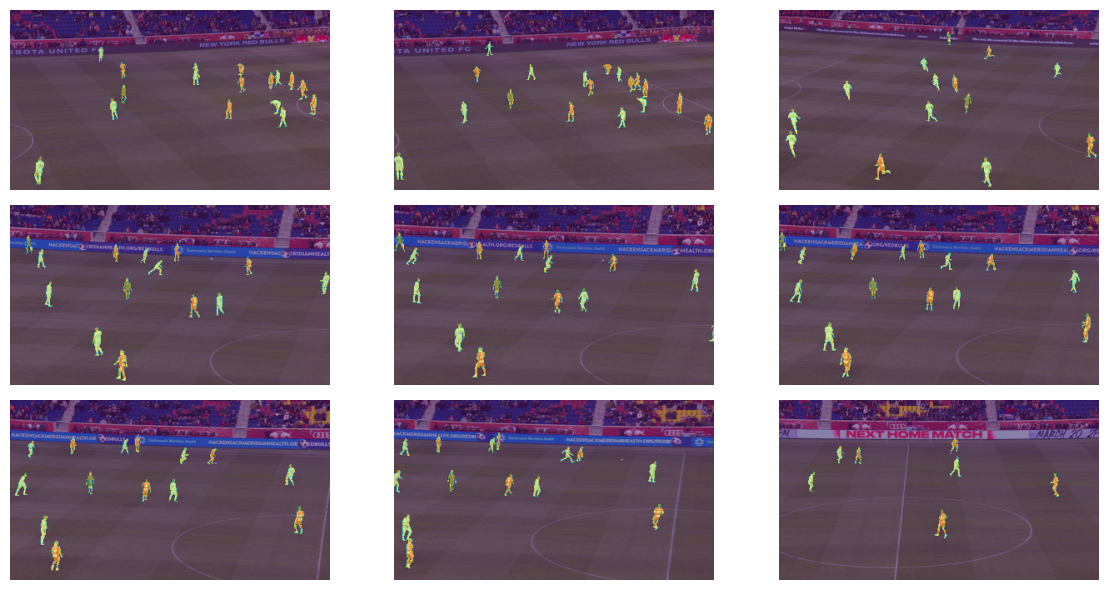

In [12]:
# masks applied on top of the images
fig = plt.figure(figsize=(12, 6))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i]/255)
    plt.imshow(masks[i], alpha=0.5)
    plt.axis('off')

fig.tight_layout()

## Torch Dataset

In [13]:
image_filenames = np.array(list(map(lambda p: str(IMAGES_DIR / p), image_id_map.values())))

In [14]:
from sklearn.model_selection import train_test_split

images_train, images_test, masks_train, masks_test = train_test_split(image_filenames, masks, test_size=0.1, random_state=180)
images_train, images_val, masks_train, masks_val = train_test_split(images_train, masks_train, test_size=0.1127, random_state=180) # 0.1 * 0.9 = 0.1127

In [15]:
images_train.shape[0], images_val.shape[0], images_test.shape[0]

(408, 52, 52)

In [16]:
import torch

from torchvision.transforms import v2

image_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=[IMAGE_SIZE[1], IMAGE_SIZE[0]])
])

mask_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

In [17]:
from recognizer.datasets import BaseDataset

train_dataset = BaseDataset(
    image_filenames=images_train,
    masks=masks_train,
    transform=image_transform,
    target_transform=mask_transform
)

val_dataset = BaseDataset(
    image_filenames=images_val,
    masks=masks_val,
    transform=image_transform,
    target_transform=mask_transform
)

test_dataset = BaseDataset(
    image_filenames=images_test,
    masks=masks_test,
    transform=image_transform,
    target_transform=mask_transform
)

In [18]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=False, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, drop_last=False)

# Model: UNet

Implementation taken from:
- https://paperswithcode.com/method/u-net
- https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py

# Lightning

In [19]:
from recognizer.models.unet import UNet

unet_model = UNet(n_channels=3, n_classes=1)

In [20]:
from torchinfo import summary

summary(unet_model)

Layer (type:depth-idx)                        Param #
UNet                                          --
├─DoubleConv: 1-1                             --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       1,792
│    │    └─BatchNorm2d: 3-2                  128
│    │    └─ReLU: 3-3                         --
│    │    └─Conv2d: 3-4                       36,928
│    │    └─BatchNorm2d: 3-5                  128
│    │    └─ReLU: 3-6                         --
├─Down: 1-2                                   --
│    └─Sequential: 2-2                        --
│    │    └─MaxPool2d: 3-7                    --
│    │    └─DoubleConv: 3-8                   221,952
├─Down: 1-3                                   --
│    └─Sequential: 2-3                        --
│    │    └─MaxPool2d: 3-9                    --
│    │    └─DoubleConv: 3-10                  886,272
├─Down: 1-4                                   --
│    └─Sequential: 2-4                       

In [21]:
import torch

x = torch.randn(1, 3, 216, 384)
preds = unet_model(x)
print(preds.shape)

torch.Size([1, 1, 216, 384])


In [22]:
import lightning as L
from torch import nn


class LitSegmenter(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        y_hat = self.model(x)
        loss = nn.BCEWithLogitsLoss(y_hat, y)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


segmenter = LitSegmenter(model=unet_model)

In [23]:
trainer = L.Trainer(fast_dev_run=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/facundopalavecino/Library/Caches/pypoetry/virtualenvs/football-players-recognizer-8BLejKao-py3.9/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


In [24]:
trainer.fit(model=segmenter, train_dataloaders=train_loader, val_dataloaders=val_loader)

/Users/facundopalavecino/Library/Caches/pypoetry/virtualenvs/football-players-recognizer-8BLejKao-py3.9/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 17.3 M
-------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.070    Total estimated model params size (MB)
/Users/facundopalavecino/Library/Caches/pypoetry/virtualenvs/football-players-recognizer-8BLejKao-py3.9/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

/Users/facundopalavecino/Library/Caches/pypoetry/virtualenvs/football-players-recognizer-8BLejKao-py3.9/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
